### NLP : RNN

##### Required tools : pytorch, python 3.6
`conda install pytorch torchvision -c pytorch`

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))



['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


##### Turn a Unicode string to plain ASCII

In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


##### Build the category_lines dictionary, a list of names per language

In [3]:
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

print(category_lines['French'][:5])

['Abel', 'Abraham', 'Adam', 'Albert', 'Allard']


##### Find letter index from all_letters, e.g. "a" = 0

In [4]:
import torch


def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


### Creating the Network

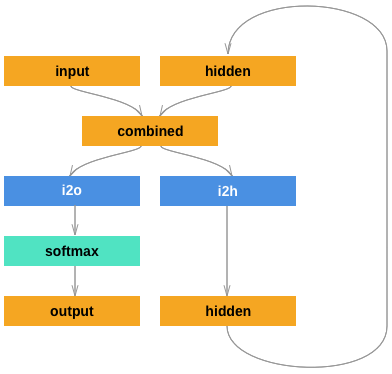

In [5]:
from IPython.display import Image
Image(filename='nn.png')

In [6]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step)

In [7]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don’t want to be creating a new Tensor for every step, so we will use lineToTensor instead of letterToTensor and use slices. This could be further optimized by pre-computing batches of Tensors.

In [8]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8742, -2.9080, -2.8899, -2.8269, -2.8773, -3.0043, -3.0001, -2.7991,
         -2.9338, -2.8706, -2.8450, -2.8826, -2.9819, -2.8700, -2.7712, -2.8754,
         -2.9342, -2.9161]], grad_fn=<LogSoftmaxBackward>)


##### Preparing for Training
Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use Tensor.topk to get the index of the greatest value:

In [14]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Vietnamese / line = Phan
category = Russian / line = Cherukhin
category = Italian / line = Caro
category = Portuguese / line = Almeida
category = Italian / line = Bruno
category = Irish / line = Niadh
category = Italian / line = Basso
category = Arabic / line = Awad
category = Portuguese / line = Rosario
category = Arabic / line = Mustafa


Each loop of training will:

- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and
- Keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [17]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Scottish', 14)


For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.

In [18]:
criterion = nn.NLLLoss()

In [19]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [24]:
import time
import math

n_iters = 100000
print_every = 500
plot_every = 100

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 0% (0m 1s) 1.7294 Serafim / Spanish ✗ (Portuguese)
1000 1% (0m 3s) 1.6998 Paredes / Portuguese ✗ (Spanish)
1500 1% (0m 4s) 2.0159 Spiker / German ✗ (Dutch)
2000 2% (0m 6s) 1.5159 Trujillo / Italian ✗ (Spanish)
2500 2% (0m 7s) 1.2554 Giang / Vietnamese ✓
3000 3% (0m 9s) 2.3137 Peij / Korean ✗ (Dutch)
3500 3% (0m 10s) 0.9130 Heel / Dutch ✓
4000 4% (0m 11s) 0.3159 Shibata / Japanese ✓
4500 4% (0m 12s) 2.1828 Uhlik / Scottish ✗ (Czech)
5000 5% (0m 13s) 0.8366 Sakelaris / Greek ✓
5500 5% (0m 14s) 2.2572 Cabral / Arabic ✗ (Portuguese)
6000 6% (0m 16s) 1.3696 Rutten / Dutch ✓
6500 6% (0m 18s) 0.4736 Yeon / Korean ✓
7000 7% (0m 19s) 2.3200 Leandres / Portuguese ✗ (French)
7500 7% (0m 20s) 3.3437 Stroman / French ✗ (German)
8000 8% (0m 21s) 4.4107 Dyo / Korean ✗ (Russian)
8500 8% (0m 23s) 2.4347 Pander / Arabic ✗ (Dutch)
9000 9% (0m 24s) 0.9921 Holtzer / German ✓
9500 9% (0m 26s) 2.7767 Soucy / Arabic ✗ (French)
10000 10% (0m 28s) 4.1271 Ogterop / Greek ✗ (Dutch)
10500 10% (0m 29s) 2.2649 H

83000 83% (4m 50s) 1.4403 Abadi / Japanese ✗ (Arabic)
83500 83% (4m 52s) 1.1512 Maguire / Irish ✓
84000 84% (4m 53s) 0.5178 Naoimhin / Irish ✓
84500 84% (4m 56s) 1.7402 Hill / English ✗ (Scottish)
85000 85% (4m 58s) 1.0748 Mooney / Irish ✓
85500 85% (5m 0s) 3.4110 Wiegand / English ✗ (German)
86000 86% (5m 2s) 1.0563 Awdyushin / Irish ✗ (Russian)
86500 86% (5m 4s) 0.8312 Ciardha / Italian ✗ (Irish)
87000 87% (5m 6s) 0.3653 Macdonald / Scottish ✓
87500 87% (5m 7s) 1.2624 Luong / Chinese ✗ (Vietnamese)
88000 88% (5m 9s) 0.6956 Sokolofsky / Polish ✓
88500 88% (5m 11s) 2.7345 Wolf / Scottish ✗ (German)
89000 89% (5m 12s) 1.6988 Behrend / Dutch ✗ (German)
89500 89% (5m 14s) 1.8530 Janoch / Irish ✗ (Czech)
90000 90% (5m 16s) 0.7435 Legrand / French ✓
90500 90% (5m 18s) 1.4510 Wright / German ✗ (Scottish)
91000 91% (5m 20s) 0.9751 Kuffel / Czech ✓
91500 91% (5m 21s) 0.7571 Cao / Vietnamese ✓
92000 92% (5m 23s) 1.3530 Melo / Spanish ✗ (Portuguese)
92500 92% (5m 25s) 1.2947 Schmidt / German ✓
9

##### Plotting the Results
Plotting the historical loss from all_losses shows the network learning:

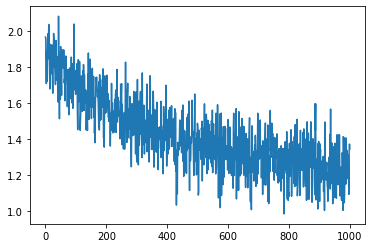

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

##### Evaluating the Results
To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

<ipython-input-26-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-26-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


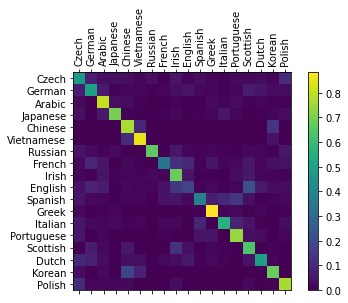

In [26]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

##### Running on User Input

In [27]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


In [39]:
predict("Samiatou")
predict("Mahougnon")
predict("Mondukpe")
predict("Benoît") 
predict("Vladimir") 
predict("Piotr")
predict("Uzumaki")
predict("Uchiwa")
predict("Jugo")
predict("Angela") 
predict("Thorkell")
predict("Ragnar")
predict("Iris")
predict("Luckman") 
predict("Fernardez")
predict("Jessy") 
predict("Roméo")
predict("Arafat")


> Samiatou
(-0.99) Greek
(-1.54) French
(-1.82) Polish

> Mahougnon
(-1.01) Russian
(-1.30) English
(-2.52) Irish

> Mondukpe
(-1.32) English
(-1.36) Scottish
(-1.60) Czech

> Benoît
(-1.53) French
(-1.71) Arabic
(-2.10) Czech

> Vladimir
(-0.87) Czech
(-1.35) Russian
(-2.16) German

> Piotr
(-1.11) German
(-1.98) Czech
(-2.12) English

> Uzumaki
(-0.27) Japanese
(-2.11) Russian
(-2.72) Polish

> Uchiwa
(-0.21) Japanese
(-3.07) Czech
(-3.81) Polish

> Jugo
(-0.58) Korean
(-2.09) Portuguese
(-2.54) Vietnamese

> Angela
(-0.69) Spanish
(-1.41) Scottish
(-2.76) Portuguese

> Thorkell
(-1.08) Czech
(-1.33) English
(-2.18) Russian

> Ragnar
(-1.25) Scottish
(-1.42) Arabic
(-2.29) Czech

> Iris
(-0.83) Greek
(-1.48) Arabic
(-1.94) Portuguese

> Luckman
(-1.24) English
(-1.84) Czech
(-1.89) Russian

> Fernardez
(-0.53) Spanish
(-2.08) Portuguese
(-2.24) German

> Jessy
(-0.70) Scottish
(-1.51) Czech
(-1.99) English

> Roméo
(-0.56) Portuguese
(-1.72) Italian
(-1.81) Spanish

> Arafat
(-1.01)